In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler


# select device: change to 'cpu' if there's no GPU device
device = torch.device('cuda:0')

In [0]:
# invertible neural network
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask):
        super(RealNVP, self).__init__()
        
        self.mask = nn.Parameter(mask, requires_grad=False).to(device)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def f(self, z):
        x = z
        log_det_J = z.new_zeros(z.shape[0])
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
            log_det_J += s.sum(dim=1)
        return x, log_det_J

    def f_inv(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

In [0]:
nets = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2), nn.Tanh()).to(device)
nett = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2)).to(device)
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32)).to(device)


In [0]:
# number of mixture components
K = 10

In [0]:
flow_list = [RealNVP(nets, nett, masks) for _ in range(K)]

net_pi = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), 
                               nn.LeakyReLU(), nn.Linear(256, K), nn.Softmax(dim=1)).to(device)

flow_pi = net_pi()

In [0]:
# n: training batch size

n = 1000

In [0]:
# the target log-prior-likelihood

p = 2

class Loglik(nn.Module):
    def __init__(self):
        super(Loglik, self).__init__()
        sigma0 = 1

        Sigma1 = torch.tensor(np.reshape(np.array([1,0.5,0.5,1], np.float32),[2,2])).to(device) * sigma0**2
        Sigma2 = torch.tensor(np.reshape(np.array([1,-0.9,-0.9,1], np.float32),[2,2])).to(device) * sigma0**2

        self.Omega1 = (Sigma1).inverse()
        self.Omega2 = (Sigma2).inverse()

        self.Mu1 = torch.tensor(np.matrix([1,2],dtype= np.float32)).to(device)
        self.Mu2 = torch.tensor(np.matrix([6,2],dtype= np.float32)).to(device)
              
    def f(self, z):
        Mu1 = self.Mu1
        Mu2 = self.Mu2
        Omega1 = self.Omega1
        Omega2 = self.Omega2
        
        d = z-Mu1
        s1 =- torch.diag(d@Omega1@d.t())/2.0 + torch.logdet(Omega1)/2.0

        d = z-Mu2
        s2 =- torch.diag(d@Omega2@d.t())/2.0 + torch.logdet(Omega2)/2.0
    
        return  torch.logsumexp(torch.stack([s1,s2]),dim=0) - np.log(2.0)

compLoglik = Loglik()

def loglik(z):
    d = z-Mu1
    s1 = - torch.diag(d@Omega1@d.t())/2.0

    d = z-Mu2
    s2 =- torch.diag(d@Omega2@d.t())/2.0
    
    return  torch.logsumexp(torch.stack([s1,s2]),dim=0)

# the reference density: we use uniform here.


def logReferenceDensity(z):
    return 0

In [0]:
para_list = list()

In [0]:
for flow in flow_list:
    para_list+= list(flow.parameters())
    
para_list +=  list(flow_pi.parameters())

In [0]:
optimizer = torch.optim.Adam([p for p in para_list if p.requires_grad==True], lr=1e-4)

In [0]:
import copy


best_loss = np.inf

Optimize to learn the random transport, as a mixture of K maps

In [0]:
for t in range(3000):
    
    x = torch.rand([n,p]).to(device)
    
    Loglik_list = list()
    z_list = list()
    
    for k in range(K):

        flow = flow_list[k]
        z_cad, logdetJ = flow.f(x)
        Loglik_list.append(compLoglik.f(z_cad)+logdetJ + torch.log(flow_pi(z_cad)[:,k]))
#         z_list.append(z_cad) 
        
    total_loglik = torch.logsumexp(torch.stack(Loglik_list), dim=0) - logReferenceDensity(x)
        
    loss =  -  total_loglik.mean()
    
    if t%50==0:
        print(t, loss.item())
        
    if loss.item()< best_loss:
        best_model= copy.deepcopy([flow_list , flow_pi])
        best_loss = loss.item()
          

    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward(retain_graph=True)

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

0 1.7610108852386475
50 -1.474622130393982
100 -1.653828501701355
150 -1.7182953357696533
200 -1.7337361574172974
250 -1.7510485649108887
300 -1.7461456060409546
350 -1.7386006116867065
400 -1.737061619758606
450 -1.7510013580322266
500 -1.766456961631775
550 -1.7683136463165283
600 -1.7596423625946045
650 -1.7512208223342896
700 -1.7963776588439941
750 -1.7482857704162598
800 -1.791283369064331
850 -1.7902171611785889
900 -1.797846794128418
950 -1.7755662202835083
1000 -1.7719537019729614
1050 -1.7846524715423584
1100 -1.8010444641113281
1150 -1.795754313468933
1200 -1.7894089221954346
1250 -1.7901207208633423
1300 -1.7904716730117798
1350 -1.7919673919677734
1400 -1.7980005741119385
1450 -1.78057062625885
1500 -1.797916054725647
1550 -1.8118606805801392
1600 -1.7994998693466187
1650 -1.7995553016662598
1700 -1.7987556457519531
1750 -1.7812894582748413
1800 -1.7951053380966187
1850 -1.7918318510055542
1900 -1.7942739725112915
1950 -1.798558235168457
2000 -1.782884955406189
2050 -1.798

In [0]:
# function to generate new Z:

from torch.distributions import gumbel

gum_rng= gumbel.Gumbel(0,1)

def soft_multinomial(Pi):
    lam = 0.1
    return torch.softmax((Pi.log() + gum_rng.sample(Pi.shape).to(device))/lam,1)


def soft_multinomial_log(logPi):
    lam = 0.1
    return torch.softmax((logPi + gum_rng.sample(logPi.shape).to(device))/lam,1)

def get_z(model, x):
    
    flow_list = model[0]
    flow_pi = model[1]
    
    Loglik_list = list()
    z_list = list()
    
    for k in range(K):

        flow = flow_list[k]
        z_cad, logdetJ = flow.f(x)
        Loglik_list.append(compLoglik.f(z_cad)+logdetJ + torch.log(flow_pi(z_cad)[:,k]))
        z_list.append(z_cad) 
        
    total_loglik = torch.logsumexp(torch.stack(Loglik_list), dim=0)
        
    loss =  -  total_loglik.mean()
        
    c = soft_multinomial_log(torch.stack(Loglik_list).t())
    z_candidates = torch.stack(z_list)
    z = torch.stack( [c[i]@ z_candidates[:,i,:] for i in range(x.shape[0])])
    
    return z

Generate target Z via random transport


In [0]:

x = torch.rand([int(5E3),p]).to(device)

Loglik_list = list()
z_list = list()

for k in range(K):

    flow = flow_list[k]
    z_cad, logdetJ = flow.f(x)
    Loglik_list.append(compLoglik.f(z_cad)+logdetJ + torch.log(flow_pi(z_cad)[:,k]))
    z_list.append(z_cad) 

g = -( torch.logsumexp(torch.stack(Loglik_list), dim=0) - logReferenceDensity(x)).detach().cpu().numpy()


c = soft_multinomial_log(torch.stack(Loglik_list).t())
z_candidates = torch.stack(z_list)
z = torch.stack( [c[i]@ z_candidates[:,i,:] for i in range(x.shape[0])]).detach().cpu().numpy()

Scatterplot of Normal Mixture

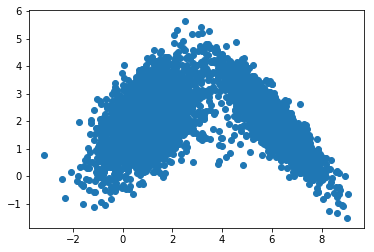

In [0]:
plt.scatter(z[:,0],z[:,1])

Approximation Error: empirical KL divergence

In [0]:
g.mean() -( -np.log(2*np.pi))

0.023392470156903933